In [3]:
# IMPORTS
import os
import numpy as np
import cv2
from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split
import skimage.io as io
import matplotlib.pyplot as plt
from tqdm import tqdm

### Read Dataset


In [4]:
def read_images(folder_path, labels=False):
    '''
     Read images from a folder and return them as a list of numpy arrays.
     Normalize the images
    '''
    images = []
    file_names = os.listdir(folder_path)
    for file_name in file_names:
        image = io.imread(os.path.join(folder_path, file_name))
        if not labels:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images.append(image)

    return images


# read dataset
A = read_images('dataset/trainval/A')  # initial images
B = read_images('dataset/trainval/B')  # images after a certain amount of time
# ground truth images (actual change)
labels = read_images('dataset/trainval/label', labels=True)

assert len(A) == len(B) == len(
    labels), "Number of images in A, B and labels are not equal."

In [5]:
# Split dataset into training, validation and test sets
A_train, A_test, B_train, B_test, labels_train, labels_test = train_test_split(
    A, B, labels, test_size=0.3, random_state=42)

# we can use the same function to split the training set into training and validation sets
# A_train, A_val, B_train, B_val, labels_train, labels_val = train_test_split(A_train, B_train, labels_train, test_size=0.2, random_state=42)

## Research findings: <br>

1. I think the most appropriate approach given the dataset is ab Object-Based Chnage Detection (By adopting an object-based approach, you can achieve more accurate and meaningful results for change detection in complex landscapes such as desert areas, where pixel-based methods may be less effective due to spatial heterogeneity and spectral variability.) and since our dataset is detecting change in desert areas, specifically buildings.
2. For image prerpcessing: first step is to apply radiometric normalization to remove the atmospheric effect and any noise


Random index:  25
Random image before change


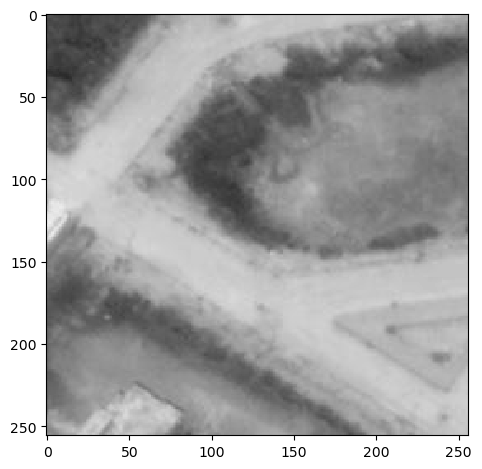

Random image after change


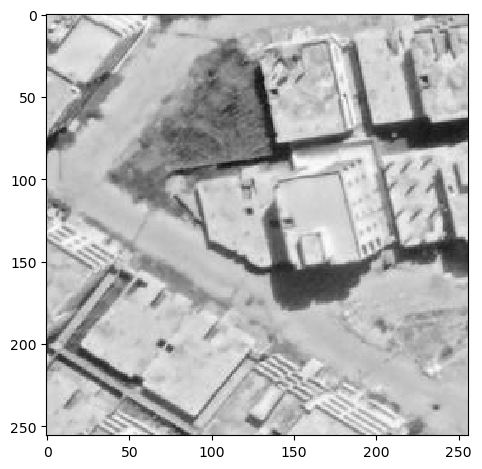

Change ground truth of the random image


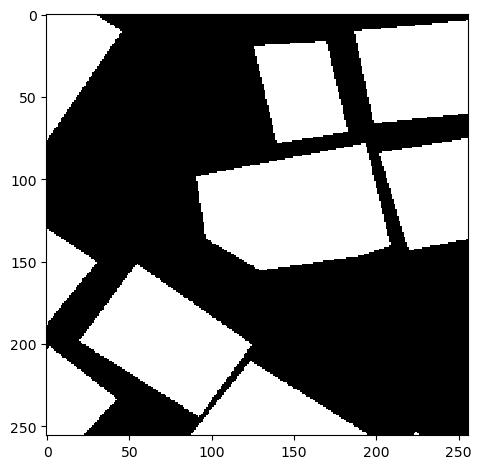

In [6]:
# 427 => white line

# Show first image in the training set
# np.random.seed(968652)
# random_index = np.random.randint(0, len(A_train))
# random_index = 21
random_index = 25
print("Random index: ", random_index)
print("Random image before change")
io.imshow(A_train[random_index])
io.show()

print("Random image after change")
io.imshow(B_train[random_index])
io.show()

print("Change ground truth of the random image")
io.imshow(labels_train[random_index])
io.show()

### Image Preprocessing


In [18]:
# For image preprocessing there are 3 main steps to try:
# 1. Radiometric correction
# 2. Geometric correction
# 3. Image enhancement
'''
There are four main types of radiometric correction: radiometric calibration, atmospheric correction, topographic correction, and sensor normalization:
1. Radiometric calibration converts the digital numbers (DN) of the image pixels to physical units, such as radiance or reflectance. 
2. Atmospheric correction removes or reduces the effects of atmospheric scattering, absorption, and haze on the image. 
3. Topographic correction adjusts the image for the variations in illumination and reflectance caused by the terrain relief. 
4. Sensor normalization harmonizes the images from different sensors or dates by eliminating the differences in radiometric characteristics.
'''

'\nThere are four main types of radiometric correction: radiometric calibration, atmospheric correction, topographic correction, and sensor normalization:\n1. Radiometric calibration converts the digital numbers (DN) of the image pixels to physical units, such as radiance or reflectance. \n2. Atmospheric correction removes or reduces the effects of atmospheric scattering, absorption, and haze on the image. \n3. Topographic correction adjusts the image for the variations in illumination and reflectance caused by the terrain relief. \n4. Sensor normalization harmonizes the images from different sensors or dates by eliminating the differences in radiometric characteristics.\n'

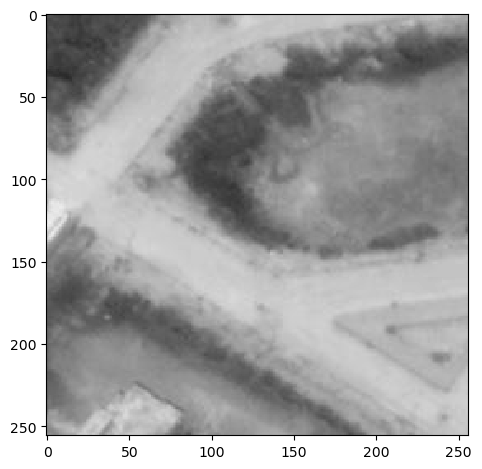

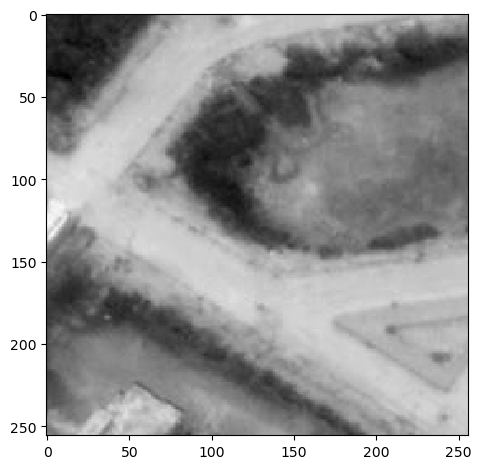

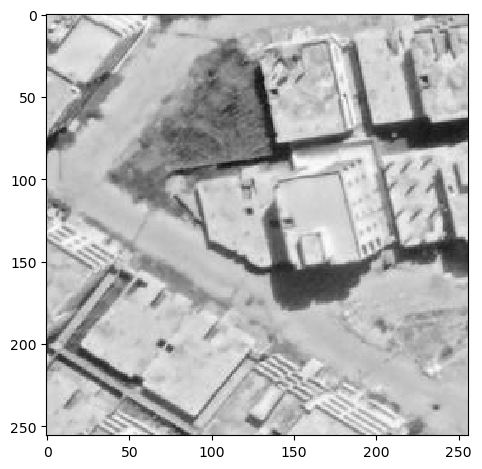

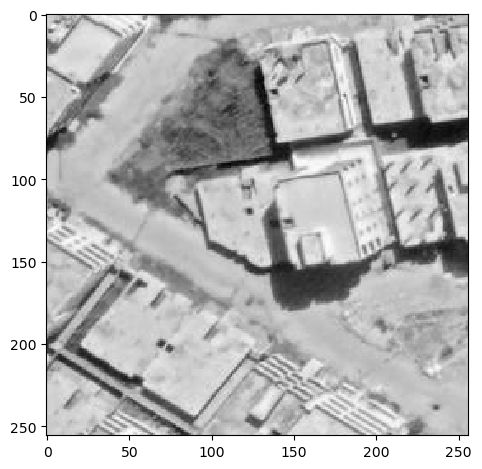

In [12]:
# Applying radiometric correction on a single image before and after

# Convert to floating point for radiometric correction
image_float_A = A_train[random_index].astype(np.float32)
image_float_B = B_train[random_index].astype(np.float32)

# Radiometric correction (e.g., flat field correction, atmospheric correction)
# Example: Subtract mean and divide by standard deviation
mean = np.mean(image_float_A)
std_dev = np.std(image_float_A)
corrected_image = (image_float_A - mean) / std_dev

# Normalize the corrected image to [0, 255]
normalized_image_A = cv2.normalize(
    corrected_image, None, 0, 255, cv2.NORM_MINMAX)
normalized_image_B = cv2.normalize(
    image_float_B, None, 0, 255, cv2.NORM_MINMAX)

# Convert back to uint8 format
normalized_image_A = np.uint8(normalized_image_A)
normalized_image_B = np.uint8(normalized_image_B)

# Display the original and normalized images
io.imshow(A_train[random_index])
io.show()
io.imshow(normalized_image_A)
io.show()

io.imshow(B_train[random_index])
io.show()
io.imshow(normalized_image_B)
io.show()

In [8]:
def get_mask(img_A, img_B, verbose = False):
    # gray_image_A = cv2.cvtColor(img_A, cv2.COLOR_BGR2GRAY)
    # gray_image_B = cv2.cvtColor(img_B, cv2.COLOR_BGR2GRAY)

    # equalize histograms
    gray_image_A = cv2.equalizeHist(img_A)
    gray_image_B = cv2.equalizeHist(img_B)

    # gaussian blur
    gray_image_A = cv2.GaussianBlur(gray_image_A, (15, 15), 0)
    gray_image_B = cv2.GaussianBlur(gray_image_B, (15, 15), 0)

    # Compute the absolute difference between the two images
    difference_image = cv2.absdiff(gray_image_A, gray_image_B)
    # show the difference image
    difference_image = cv2.bitwise_not(difference_image)
    if verbose:
        io.imshow(difference_image)
        io.show()
    # difference_image = cv2.medianBlur(difference_image, 7)


    # edge detection using Canny
    edges = cv2.Canny(difference_image, 140, 200, 3, L2gradient=True)
    if verbose:
        io.imshow(edges)
        io.show()




    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=2)
    if verbose:
        io.imshow(closed_edges)
        io.show()
    closed_edges = cv2.morphologyEx(closed_edges, cv2.MORPH_DILATE, kernel, iterations=1)
    if verbose:
        io.imshow(closed_edges)
        io.show()
    # filter
    closed_edges = cv2.medianBlur(closed_edges, 5)
    closed_edges = cv2.morphologyEx(closed_edges, cv2.MORPH_CLOSE, kernel, iterations=3)
    closed_edges = cv2.medianBlur(closed_edges, 5)
    if verbose:
        io.imshow(closed_edges)
        io.show()
    closed_edges = cv2.morphologyEx(closed_edges, cv2.MORPH_DILATE, kernel, iterations=1)
    closed_edges = cv2.medianBlur(closed_edges, 5)
    if verbose:
    # closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=1)
    # closed_edges = cv2.morphologyEx(edges, cv2.MORPH_OPEN, kernel, iterations=1)
        io.imshow(closed_edges)
        io.show()



    # find countours
    contours, _ = cv2.findContours(
        closed_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    img_copy = np.ones((256, 256), dtype=np.uint8)

    cv2.drawContours(img_copy, contours, -1, (255), thickness=cv2.FILLED)
    if verbose:
        print("Contours")
        io.imshow(img_copy)
        io.show()


  
    # thresholded_image = cv2.adaptiveThreshold(
    #     difference_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 19, 2)
    # if verbose:
    #     io.imshow(thresholded_image)
    #     io.show()
    return img_copy

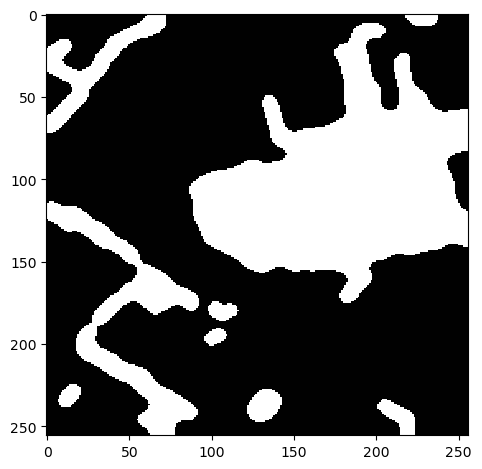

In [13]:
io.imshow(get_mask(normalized_image_A, normalized_image_B))##, verbose=True))


### Classical Technique:

#### Image Differencing


In [14]:
# # Apply image differencing to detect changes

# # convert to grayscale
# gray_image_A = cv2.cvtColor(normalized_image_A, cv2.COLOR_BGR2GRAY)
# gray_image_B = cv2.cvtColor(normalized_image_B, cv2.COLOR_BGR2GRAY)

# # equalize histograms
# gray_image_A = cv2.equalizeHist(gray_image_A)
# gray_image_B = cv2.equalizeHist(gray_image_B)

# # gaussian blur
# gray_image_A = cv2.GaussianBlur(gray_image_A, (15, 15), 0)
# gray_image_B = cv2.GaussianBlur(gray_image_B, (15, 15), 0)

# # Compute the absolute difference between the two images
# difference_image = cv2.absdiff(gray_image_A, gray_image_B)
# # show the difference image
# difference_image = cv2.bitwise_not(difference_image)
# io.imshow(difference_image)
# io.show()
# # difference_image = cv2.medianBlur(difference_image, 7)


# # edge detection using sobel
# edges = cv2.Canny(difference_image, 140, 200, 3, L2gradient=True)
# io.imshow(edges)
# io.show()

# # invert the image


# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
# closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=2)
# io.imshow(closed_edges)
# io.show()
# closed_edges = cv2.morphologyEx(
#     closed_edges, cv2.MORPH_DILATE, kernel, iterations=1)
# io.imshow(closed_edges)
# io.show()
# # filter
# closed_edges = cv2.medianBlur(closed_edges, 5)
# closed_edges = cv2.morphologyEx(
#     closed_edges, cv2.MORPH_CLOSE, kernel, iterations=3)
# closed_edges = cv2.medianBlur(closed_edges, 5)
# io.imshow(closed_edges)
# io.show()
# closed_edges = cv2.morphologyEx(
#     closed_edges, cv2.MORPH_DILATE, kernel, iterations=1)
# closed_edges = cv2.medianBlur(closed_edges, 5)
# # closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=1)
# # closed_edges = cv2.morphologyEx(edges, cv2.MORPH_OPEN, kernel, iterations=1)
# io.imshow(closed_edges)
# io.show()


# # find countours
# contours, _ = cv2.findContours(
#     closed_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# # contours, hierarchy = cv2.findContours(closed_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# # # print(contours)
# # # draw contours filled
# # # img_copy = cv2.cvtColor(normalized_image_B, cv2.COLOR_BGR2GRAY).copy()
# # # new image of size 256*256 and all zeros
# img_copy = np.ones((256, 256), dtype=np.uint8)

# cv2.drawContours(img_copy, contours, -1, (255), thickness=cv2.FILLED)

# print("Contours")
# io.imshow(img_copy)
# io.show()


# # # temp = cv2.threshold(difference_image , 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
# # temp = cv2.threshold(difference_image, 250, 255, cv2.THRESH_BINARY)[1]
# # io.imshow(temp)

# # # filter using gaussian blur
# # edges = cv2.medianBlur(edges, 1)


# # # close
# # # kernel = np.ones((5, 5), np.uint8)


# # # open
# # # # kernel = np.ones((5, 5), np.uint8)
# # # closed_edges = cv2.morphologyEx(closed_edges, cv2.MORPH_OPEN, kernel, iterations=1)
# # # io.imshow(closed_edges)
# # # io.show()


# # # # kernel[2, :] = 1
# # # closed_edges = cv2.morphologyEx(closed_edges, cv2.MORPH_CLOSE, kernel, iterations=2)
# # # io.imshow(closed_edges)
# # # io.show()


# # # invert the image
# # # closed_edges = cv2.bitwise_not(closed_edges)
# # # io.imshow(closed_edges)
# # # io.show()

# # # kernel = np.ones((5,5), np.uint8)
# # # opened_edges = cv2.morphologyEx(closed_edges, cv2.MORPH_OPEN, kernel)
# # # io.imshow(opened_edges )
# # # io.show()

# # # # dilate edges
# # # kernel = np.ones((5,5), np.uint8)
# # # dilated_edges = cv2.dilate(edges, kernel, iterations=1)
# # # io.imshow(dilated_edges)
# # # io.show()

# # # # erode edges
# # # kernel = np.ones((5, 5), np.uint8)
# # # eroded_edges = cv2.erode(dilated_edges, kernel, iterations=1)
# # # io.imshow(eroded_edges)
# # # io.show()


# # # filter edges
# # closed_edges= cv2.medianBlur(closed_edges, 1)
# # # io.imshow(edges)
# # # io.show()


# # invert the image

# # apply threshold to the difference image
# # get the optimal threshold for the image
# thresholded_image = cv2.adaptiveThreshold(
#     difference_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 19, 2)

# io.imshow(thresholded_image)
# io.show()
# # thresholded_image = cv2.threshold(difference_image , 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
# # # multiply by the edges

# # io.imshow(thresholded_image)
# # io.show()

# # final_thresholded_image = cv2.morphologyEx(thresholded_image, cv2.MORPH_OPEN, kernel, iterations=2)

# # # show the difference image
# # io.show()

# # # show threshholded image and closed egdes side bye side
# # fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# # ax[0].imshow(thresholded_image, cmap='gray')
# # ax[0].set_title('Thresholded Image')
# # ax[1].imshow(closed_edges, cmap='gray')
# # ax[1].set_title('Closed Edges')
# # plt.show()



In [14]:
# convert images to grayscale
# gray_image_A = cv2.cvtColor(normalized_image_A, cv2.COLOR_BGR2GRAY)
# gray_image_B = cv2.cvtColor(normalized_image_B, cv2.COLOR_BGR2GRAY)
gray_image_A = normalized_image_A.copy()
gray_image_B = normalized_image_B.copy()

# compute the mean and variance for A and B
mean_A = np.mean(gray_image_A)
mean_B = np.mean(gray_image_B)
var_A = np.var(gray_image_A)
var_B = np.var(gray_image_B)

# print the mean and variance for A and B
print("Mean of A: ", mean_A)
print("Mean of B: ", mean_B)
print("Variance of A: ", var_A)
print("Variance of B: ", var_B)

Mean of A:  138.93775939941406
Mean of B:  171.92674255371094
Variance of A:  2754.4849108976778
Variance of B:  2428.7256666717585


In [10]:
def check_var_diff(img_A, img_B):
    '''
    Check if the standard deviation of the two images is different
    '''
    # std_A = np.std(img_A)
    # std_B = np.std(img_B)


    # return np.abs(std_A - std_B) / (std_A + std_B)
    
    # convert images to int
    img_A = img_A.astype(np.int32)
    img_B = img_B.astype(np.int32)
    
    var_A = np.var(img_A)
    var_B = np.var(img_B)
    
    return np.abs(var_A - var_B) / (var_A + var_B)

In [15]:
check_var_diff(gray_image_A, gray_image_B)

0.06284893105359374

In [16]:
def check_change(label, threshold = 0.02):
    '''
    Check if more than the threshold is white pixels
    '''
    # normalize the image
    label = cv2.normalize(label, None, 0, 255, cv2.NORM_MINMAX)
    white_pixels = np.sum(label == 255)
    total_pixels = label.shape[0] * label.shape[1]
    return white_pixels / total_pixels > threshold

In [17]:
def radiometric_correction(img):
    '''
    Radiometric correction of an image
    '''
    # Convert to floating point for radiometric correction
    image_float = img.astype(np.float32)

    # Radiometric correction (e.g., flat field correction, atmospheric correction)
    # Example: Subtract mean and divide by standard deviation
    mean = np.mean(image_float)
    std_dev = np.std(image_float)
    corrected_image = (image_float - mean) / std_dev

    # Normalize the corrected image to [0, 255]
    normalized_image = cv2.normalize(
        corrected_image, None, 0, 255, cv2.NORM_MINMAX)

    # Convert back to uint8 format
    normalized_image = np.uint8(normalized_image)

    return normalized_image
    

In [18]:
check_change(labels_train[random_index])

True

In [19]:
# we need to plot a histogram of the variance differences between images depending on whether there's a change or not
# loop through the images, get the std_diff between each a and b image, check if the ground truth has more than 98% black pixels,
# if it does, then there's no change, else there's a change
# if there's a change, append the variance difference to the change list, else append to the no change list

change_list = []
no_change_list = []
for i in range(len(A_train)):
    
    std_diff = check_var_diff(A_train[i], B_train[i])
    if check_change(labels_train[i]):
        change_list.append(std_diff)
    else:
        no_change_list.append(std_diff)



In [31]:
len(labels_train)

3407

In [20]:
def compute_jaccard_score(img_A, img_B):
    '''
    Compute the jacard score between two images
    '''
    # noramlize
    img_A = cv2.normalize(img_A, None, 0, 255, cv2.NORM_MINMAX)
    img_B = cv2.normalize(img_B, None, 0, 255, cv2.NORM_MINMAX)
    
    img_A = img_A.astype('int32')
    img_B = img_B.astype('int32')

    # compute the jacard score
    jacard_score = jaccard_score(img_A.flatten(), img_B.flatten(), average="micro")
    return jacard_score

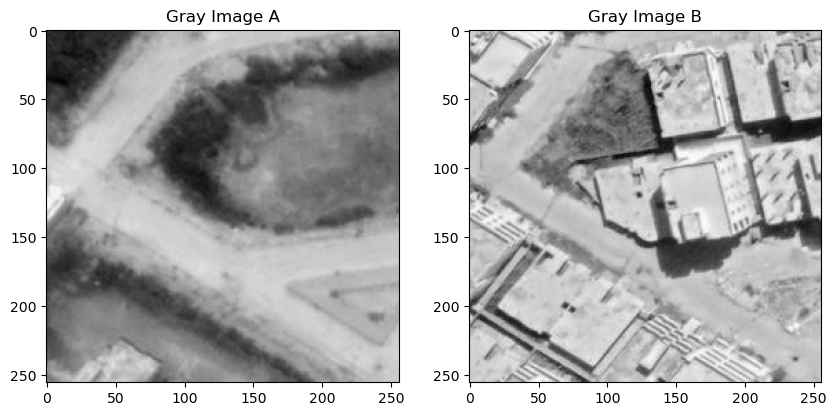

In [22]:
# plot grat_img_A and b side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(A_train[random_index], cmap="gray")
ax[0].set_title('Gray Image A')
ax[1].imshow(B_train[random_index], cmap="gray")
ax[1].set_title('Gray Image B')
plt.show()
# print()

In [23]:
compute_jaccard_score(gray_image_A, gray_image_A)

1.0

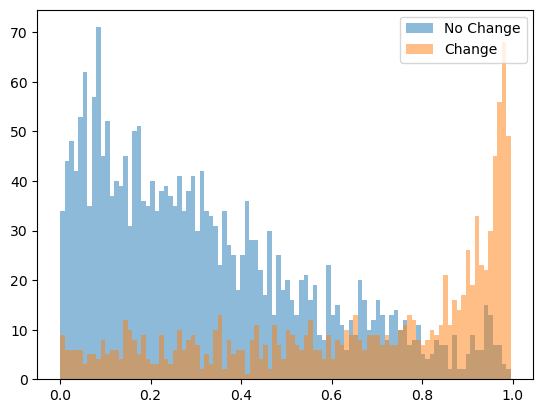

In [24]:
        
# plot the histogram
plt.hist(no_change_list, bins=100, alpha=0.5, label='No Change')
plt.hist(change_list, bins=100, alpha=0.5, label='Change')
plt.legend(loc='upper right')
plt.show()

In [26]:
# get mean of change and no change
mean_change = np.mean(change_list)
mean_no_change = np.mean(no_change_list)
print("Mean of change: ", mean_change)
print("Mean of no change: ", mean_no_change)

# std
std_change = np.std(change_list)
std_no_change = np.std(no_change_list)
print("Standard deviation of change: ", std_change)
print("Standard deviation of no change: ", std_no_change)

Mean of change:  0.6653459606257811
Mean of no change:  0.3223525913256606
Standard deviation of change:  0.30379375800970493
Standard deviation of no change:  0.2432603152016336


In [43]:

# jaccard_change_list = []
# jaccard_no_change_list = []
# for i in tqdm(range(len(A_train))):
    
#     jacard_score = compute_jaccard_score(A_train[i], B_train[i])
#     if check_change(labels_train[i]):
#         jaccard_change_list.append(jacard_score)
#     else:
#         jaccard_no_change_list.append(jacard_score)
        

100%|██████████| 3407/3407 [01:43<00:00, 32.88it/s]


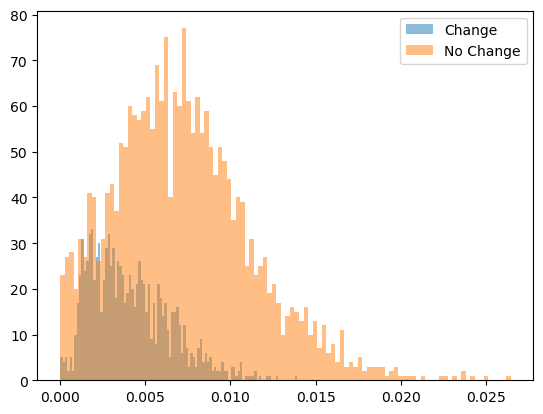

In [44]:
        
# # plot the histogram
# plt.hist(jaccard_change_list, bins=100, alpha=0.5, label='Change')
# plt.hist(jaccard_no_change_list, bins=100, alpha=0.5, label='No Change')
# plt.legend(loc='upper right')
# plt.show()

In [45]:
# # get mean of change and no change
# mean_change = np.mean(jaccard_change_list)
# mean_no_change = np.mean(jaccard_no_change_list)
# print("Mean of change: ", mean_change)
# print("Mean of no change: ", mean_no_change)
# #var
# var_change = np.var(jaccard_change_list)
# var_no_change = np.var(jaccard_no_change_list)
# print("Variance of change: ", var_change)
# print("Variance of no change: ", var_no_change)
# # std
# std_change = np.std(jaccard_change_list)
# std_no_change = np.std(jaccard_no_change_list)
# print("Standard deviation of change: ", std_change)
# print("Standard deviation of no change: ", std_no_change)

Mean of change:  0.004117381741153403
Mean of no change:  0.007194125086477156
Variance of change:  5.639277771482724e-06
Variance of no change:  1.645038397029265e-05
Standard deviation of change:  0.002374716356006065
Standard deviation of no change:  0.004055907293108738


In [44]:
# for training dataset
# we need to check for each image from a and b if there's a change
# based on the above statistics, if the variance difference between the 2 images is within the no change range
# then there's no change, else there's a change
# if there's no change, out mask will be a black image
# if there's a change, we will get the mask of the change
# then we need to compute the jaccard index between the mask and the label
# compute the average score for all the dataset
# if there's no change, the jaccard will be 1


all_jaccard = []
predicted_masks = []
change_count = 0
no_change_count = 0
# for each image in the training set
for i in tqdm(range(len(A_train))):
    # get the variance difference
    var_diff = check_var_diff(A_train[i], B_train[i])

    # check if there's a change
    # if mean_change - std_change <= var_diff <= mean_change + std_change:
    change_mask = get_mask(
        radiometric_correction(A_train[i]), radiometric_correction(B_train[i]))
    predicted_masks.append(change_mask)
    j_score = compute_jaccard_score(change_mask, labels_train[i])
    all_jaccard.append(j_score)
    change_count += 1

    # else:
    #     no_change_count += 1
    #     all_jaccard.append(1)
    #     predicted_masks.append(
    #         np.zeros((256, 256), dtype=np.uint8))

100%|██████████| 3407/3407 [01:04<00:00, 52.87it/s]


In [39]:
print(change_count, no_change_count)

1528 1879


In [45]:
np.mean(all_jaccard)

0.5169095804255235

In [46]:

test_all_jaccard = []
test_predicted_masks = []
test_change_count = 0
test_no_change_count = 0
# for each image in the testing set
for i in tqdm(range(len(A_test))):
    # get the variance difference
    var_diff = check_var_diff(A_test[i], B_test[i])

    # check if there's a change
    # if mean_change - std_change <= var_diff <= mean_change + std_change:
    change_mask = get_mask(
        radiometric_correction(A_test[i]), radiometric_correction(B_test[i]))
    test_predicted_masks.append(change_mask)
    j_score = compute_jaccard_score(change_mask, labels_test[i])
    test_all_jaccard.append(j_score)
    test_change_count += 1

    # else:
    #     test_no_change_count += 1
    #     test_all_jaccard.append(1)
    #     test_predicted_masks.append(
    #         np.zeros((256, 256), dtype=np.uint8))

  0%|          | 0/1461 [00:00<?, ?it/s]

100%|██████████| 1461/1461 [00:26<00:00, 56.00it/s]


In [47]:
np.mean(test_all_jaccard)

0.5170587891743034

In [36]:
len(predicted_masks)

1528

In [43]:
# write predictions and lables 
# for training set
for i in range(len(predicted_masks)):
    cv2.imwrite(f"dataset/predictions/train/predicted/{i}.png", predicted_masks[i])
    cv2.imwrite(f"dataset/predictions/train/ground_truth/{i}.png", labels_train[i])
    
# for testing set
for i in range(len(test_predicted_masks)):
    cv2.imwrite(f"dataset/predictions/test/predicted/{i}.png", test_predicted_masks[i])
    cv2.imwrite(f"dataset/predictions/test/ground_truth/{i}.png", labels_test[i])